In [2]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.image import imread
import cv2

import warnings
warnings.filterwarnings('ignore')

from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense, Conv2D, MaxPooling2D
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.utils import plot_model
from tensorflow.keras import backend

from sklearn.metrics import confusion_matrix, classification_report
import json
from sklearn import metrics



%matplotlib inline


In [3]:
train_path = "D:/ML_project_dataset/casting_data/casting_data/test"
test_path = "D:/ML_project_dataset/casting_data/casting_data/train"

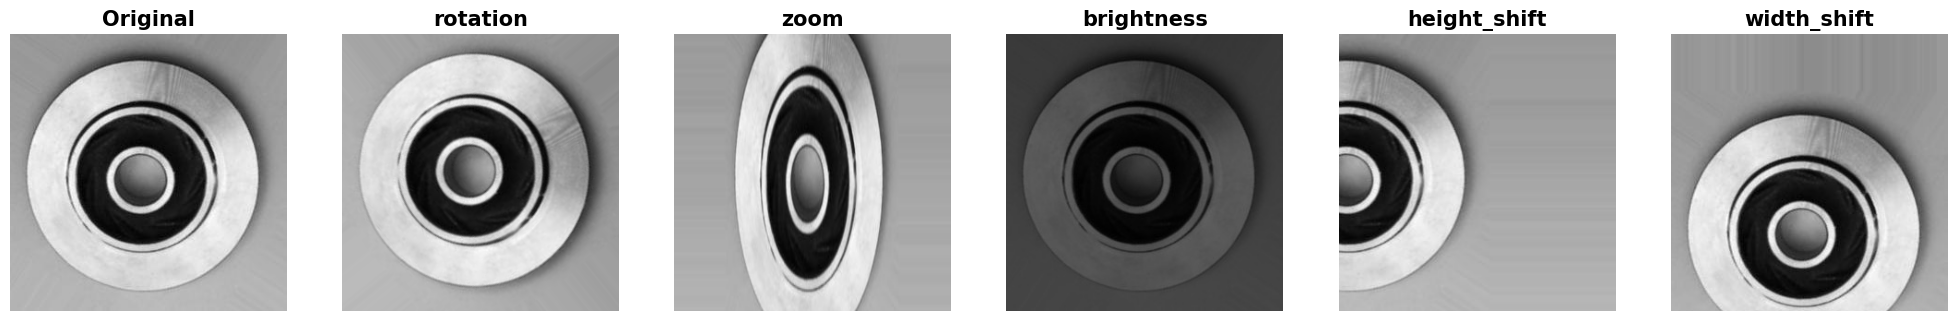

In [4]:
train_path = "D:/ML_project_dataset/casting_data/casting_data/test"
img_folder = os.path.join(train_path, 'ok_front')

image_files = [f for f in os.listdir(img_folder) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]

if not image_files:
    raise FileNotFoundError(f"No image files found in: {img_folder}")

img_path = os.path.join(img_folder, image_files[0])

img = cv2.imread(img_path)

if img is None:
    raise FileNotFoundError(f"Image not found or unable to read at {img_path}")

img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img_4d = np.expand_dims(img, axis=0)  

plt.figure(figsize=(25, 10))
generators = {
    "rotation": ImageDataGenerator(rotation_range=180),
    "zoom": ImageDataGenerator(zoom_range=0.7),
    "brightness": ImageDataGenerator(brightness_range=[0.2, 1.0]),
    "height_shift": ImageDataGenerator(height_shift_range=0.7),
    "width_shift": ImageDataGenerator(width_shift_range=0.7)
}

plt.subplot(1, 6, 1)
plt.title("Original", weight='bold', size=15)
plt.imshow(img)
plt.axis('off')

cnt = 2
for param, generator in generators.items():
    gen = generator.flow(img_4d, batch_size=1)
    g_img = next(gen)[0].astype(np.uint8)

    plt.subplot(1, 6, cnt)
    plt.title(param, weight='bold', size=15)
    plt.imshow(g_img)
    plt.axis('off')
    cnt += 1

plt.show()


In [5]:
image_gen = ImageDataGenerator(rescale=1/255, 
                               zoom_range=0.1, 
                               brightness_range=[0.9,1.0])

In [6]:
image_shape = (300,300,1) # 300 × 300、graysclaed (full-color : 3)
batch_size = 32

train_set = image_gen.flow_from_directory(train_path,
                                            target_size=image_shape[:2],
                                            color_mode="grayscale",
                                            classes={'def_front': 0, 'ok_front': 1},
                                            batch_size=batch_size,
                                            class_mode='binary',
                                            shuffle=True,
                                            seed=0)

test_set = image_gen.flow_from_directory(test_path,
                                           target_size=image_shape[:2],
                                           color_mode="grayscale",
                                           classes={'def_front': 0, 'ok_front': 1},
                                           batch_size=batch_size,
                                           class_mode='binary',
                                           shuffle=False,
                                           seed=0)

Found 2280 images belonging to 2 classes.
Found 4940 images belonging to 2 classes.


In [7]:
train_set.class_indices

{'def_front': 0, 'ok_front': 1}

In [8]:
backend.clear_session()
model = Sequential()
model.add(Conv2D(filters=16, kernel_size=(7,7), strides=2, input_shape=image_shape, activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=(2, 2), strides=2))
model.add(Conv2D(filters=32, kernel_size=(3,3), strides=1, input_shape=image_shape, activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=(2, 2), strides=2))
model.add(Conv2D(filters=64, kernel_size=(3,3), strides=1, input_shape=image_shape, activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=(2, 2), strides=2))
model.add(Flatten())
model.add(Dense(units=224, activation='relu'))
model.add(Dropout(rate=0.2))
model.add(Dense(units=1, activation='sigmoid'))
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 150, 150, 16)      800       
                                                                 
 max_pooling2d (MaxPooling2  (None, 75, 75, 16)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 75, 75, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 37, 37, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 37, 37, 64)        18496     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 18, 18, 64)        0

In [9]:
model_save_path = 'casting_product_detection.hdf5'
early_stop = EarlyStopping(monitor='val_loss',patience=2)
checkpoint = ModelCheckpoint(filepath=model_save_path, verbose=1, save_best_only=True, monitor='val_loss')

In [10]:
n_epochs = 20
results = model.fit_generator(train_set, epochs=n_epochs, validation_data=test_set, callbacks=[early_stop,checkpoint])


Epoch 1/20
72/72 [==============================] - ETA: 0s - loss: 0.6566 - accuracy: 0.6404
Epoch 1: val_loss improved from inf to 0.66226, saving model to casting_product_detection.hdf5
72/72 [==============================] - 176s 2s/step - loss: 0.6566 - accuracy: 0.6404 - val_loss: 0.6623 - val_accuracy: 0.5421
Epoch 2/20
72/72 [==============================] - ETA: 0s - loss: 0.5696 - accuracy: 0.6952
Epoch 2: val_loss improved from 0.66226 to 0.56493, saving model to casting_product_detection.hdf5
72/72 [==============================] - 76s 1s/step - loss: 0.5696 - accuracy: 0.6952 - val_loss: 0.5649 - val_accuracy: 0.6982
Epoch 3/20
72/72 [==============================] - ETA: 0s - loss: 0.4867 - accuracy: 0.7645
Epoch 3: val_loss improved from 0.56493 to 0.49067, saving model to casting_product_detection.hdf5
72/72 [==============================] - 80s 1s/step - loss: 0.4867 - accuracy: 0.7645 - val_loss: 0.4907 - val_accuracy: 0.7555
Epoch 4/20
72/72 [===================

In [11]:
model_history = { i:list(map(lambda x: float(x), j)) for i,j in results.history.items() }
with open('model_history.json', 'w') as f:
    json.dump(model_history, f, indent=4)


In [12]:
losses = pd.DataFrame(model_history)
losses.index = map(lambda x : x+1, losses.index)
losses.head(3)

,loss,accuracy,val_loss,val_accuracy
1,0.656555,0.640351,0.662262,0.542105
2,0.569553,0.695175,0.564926,0.698178
3,0.486740,0.764474,0.490675,0.755466


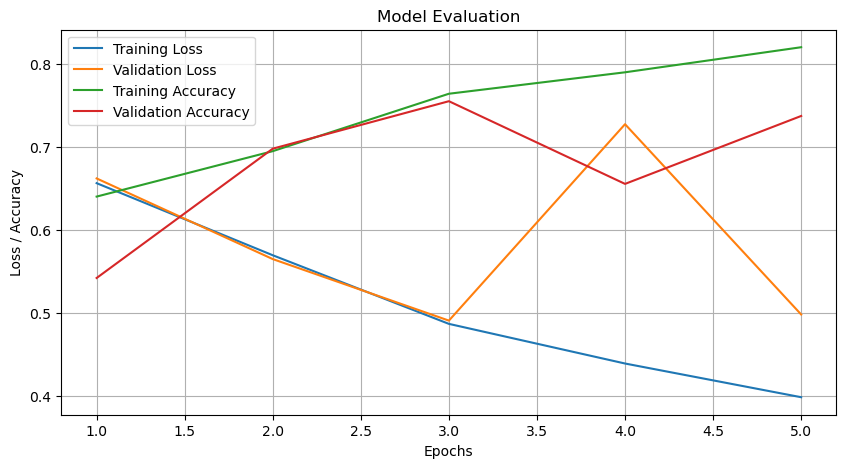

In [13]:
plt.figure(figsize=(10, 5))

sns.lineplot(data=losses, x=losses.index, y='loss', label='Training Loss')
sns.lineplot(data=losses, x=losses.index, y='val_loss', label='Validation Loss')

sns.lineplot(data=losses, x=losses.index, y='accuracy', label='Training Accuracy')
sns.lineplot(data=losses, x=losses.index, y='val_accuracy', label='Validation Accuracy')

plt.xlabel('Epochs')
plt.ylabel('Loss / Accuracy')
plt.title('Model Evaluation')
plt.legend(loc='best')
plt.grid(True)

plt.show()



155/155 [==============================] - 28s 181ms/step


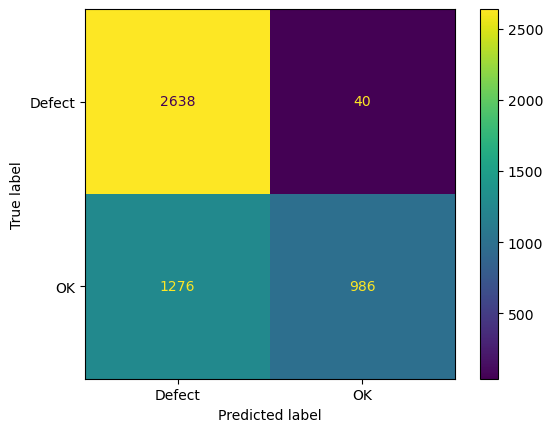

In [14]:
pred_probability = model.predict(test_set)
predictions = (pred_probability > 0.5).astype(int).reshape(-1)

conf_matrix = metrics.confusion_matrix(test_set.classes, predictions)

cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = conf_matrix, display_labels = ['Defect', 'OK'])

cm_display.plot()
plt.show()


In [15]:
print(classification_report(test_set.classes, predictions, digits=3))

              precision    recall  f1-score   support

           0      0.674     0.985     0.800      2678
           1      0.961     0.436     0.600      2262

    accuracy                          0.734      4940
   macro avg      0.818     0.710     0.700      4940
weighted avg      0.805     0.734     0.709      4940



In [16]:

test_cases = [
    'ok_front/cast_ok_0_10.jpeg', 'ok_front/cast_ok_0_1026.jpeg', 'ok_front/cast_ok_0_1031.jpeg', 
    'ok_front/cast_ok_0_1121.jpeg', 'ok_front/cast_ok_0_1144.jpeg',
    'def_front/cast_def_0_1059.jpeg', 'def_front/cast_def_0_108.jpeg', 
    'def_front/cast_def_0_1153.jpeg', 'def_front/cast_def_0_1238.jpeg', 'def_front/cast_def_0_1269.jpeg'
]

plt.figure(figsize=(20, 8))

for i, img_name in enumerate(test_cases):
    img_path = os.path.join(test_path, img_name)  

    if not os.path.exists(img_path):
        print(f"Warning: Image not found at {img_path}")
        continue

    img_pred = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)

    if img_pred is None:
        print(f"Error: Unable to read image at {img_path}")
        continue

    img_pred = img_pred / 255.0  
    prediction = model.predict(img_pred.reshape(1, *image_shape))

    img = cv2.imread(img_path)  
    label = img_name.split("_")[0]

    plt.subplot(2, 5, i + 1)
    plt.title(f"{img_name.split('/')[1]}\nActual Label: {label}", weight='bold', size=12)

    if prediction < 0.5:
        predicted_label = "def"
        prob = (1 - prediction.sum()) * 100
    else:
        predicted_label = "ok"
        prob = prediction.sum() * 100

    cv2.putText(img, f"Predicted Label: {predicted_label}", (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 
                0.8, (255, 0, 255), 2)
    cv2.putText(img, f"Probability: {'{:.3f}'.format(prob)}%", (10, 280), cv2.FONT_HERSHEY_SIMPLEX, 
                0.7, (0, 255, 0), 2)

    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.axis('off')

plt.show()


<Figure size 2000x800 with 0 Axes>

1/1 [==============================] - 0s 32ms/step


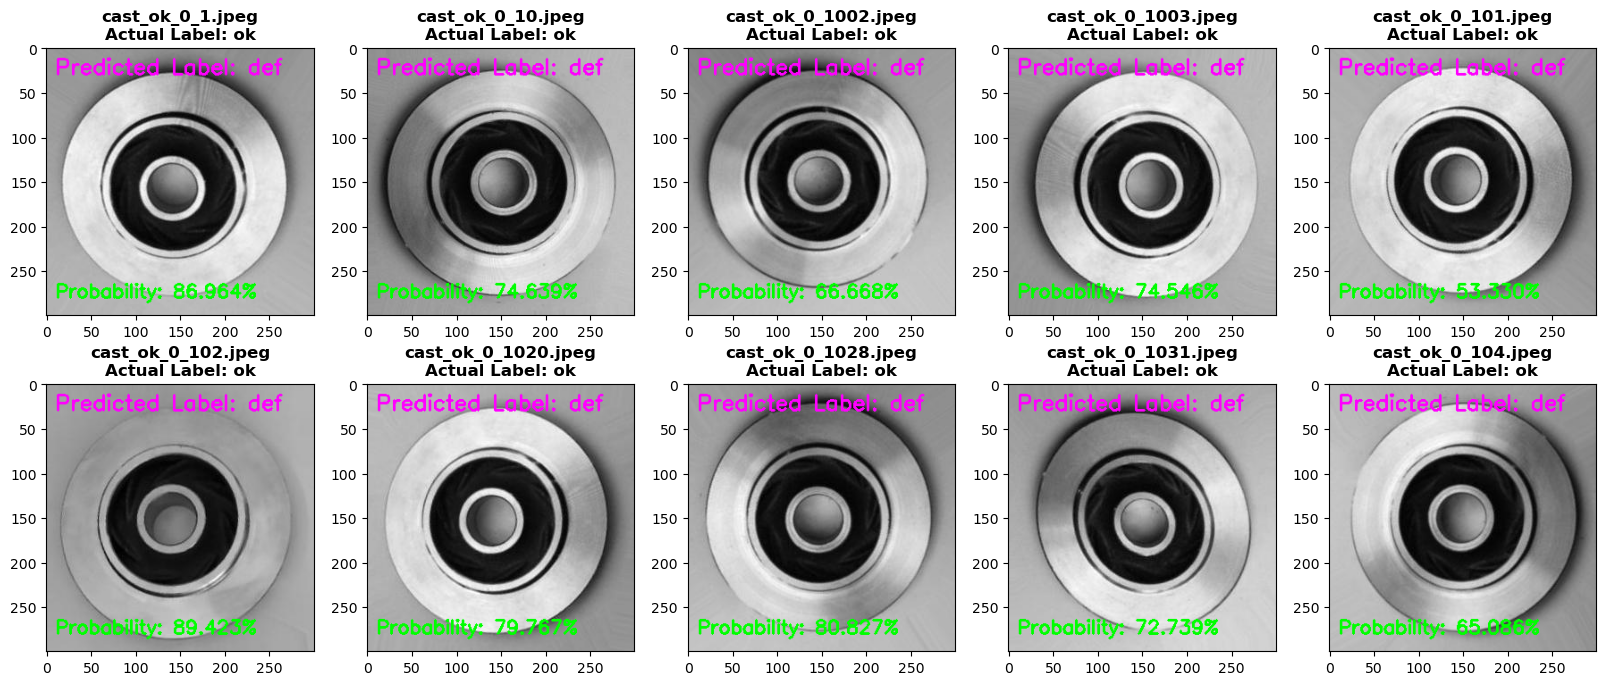

In [17]:
test_path = "D:/ML_project_dataset/casting_data/casting_data/test"

ok_front_path = os.path.join(test_path, "ok_front")
def_front_path = os.path.join(test_path, "def_front")

test_cases = ['ok_front/' + i for i in os.listdir(ok_front_path)]
test_cases.extend(['def_front/' + i for i in os.listdir(def_front_path)])

plt.figure(figsize=(20, 8))
cnt = 0 
misclassified = []

for i in range(len(test_cases)):
    if cnt == 10: 
        break  

    img_path = os.path.join(test_path, test_cases[i])  
    img_pred = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)

    img_pred = img_pred / 255  
    prediction = model.predict(img_pred.reshape(1, *image_shape))

    img = cv2.imread(img_path)
    label = test_cases[i].split("_")[0]

    if prediction < 0.5:
        predicted_label = "def"
        prob = (1 - prediction.sum()) * 100
    else:
        predicted_label = "ok"
        prob = prediction.sum() * 100

    if label != predicted_label:
        misclassified.append(test_cases[i])
        plt.subplot(2, 5, cnt + 1)
        plt.title(f"{test_cases[i].split('/')[1]}\nActual Label: {label}", weight='bold', size=12)
        cv2.putText(img, f"Predicted Label: {predicted_label}", (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 
                    0.8, (255, 0, 255), 2)
        cv2.putText(img, f"Probability: {'{:.3f}'.format(prob)}%", (10, 280), cv2.FONT_HERSHEY_SIMPLEX, 
                    0.7, (0, 255, 0), 2)
        plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))  
        cnt += 1

plt.show()


In [18]:
import cv2
import numpy as np
import tkinter as tk
from tkinter import filedialog
from PIL import Image, ImageTk
import tensorflow as tf

model = tf.keras.models.load_model("casting_product_detection.hdf5") 
# Image settings
image_shape = (300, 300, 1)

def predict_image():
    file_path = filedialog.askopenfilename(filetypes=[("Image Files", "*.jpeg;*.jpg;*.png")])
    
    if not file_path:
        return

    # Read the image
    img_gray = cv2.imread(file_path, cv2.IMREAD_GRAYSCALE)
    
    if img_gray is None:
        result_label.config(text="Error: Cannot read image", fg="red")
        return

    img_gray = cv2.resize(img_gray, (300, 300)) / 255.0
    img_gray = img_gray.reshape(1, *image_shape)

    prediction = model.predict(img_gray)[0][0]
    predicted_label = "Defective" if prediction < 0.5 else "OK"
    prob = (1 - prediction) * 100 if prediction < 0.5 else prediction * 100

    result_label.config(text=f"Prediction: {predicted_label} ({prob:.2f}%)", fg="blue")

    img = Image.open(file_path)
    img = img.resize((200, 200))
    img = ImageTk.PhotoImage(img)
    
    image_label.config(image=img)
    image_label.image = img  


root = tk.Tk()
root.title("Casting Defect Detection")
root.geometry("400x400")

btn = tk.Button(root, text="Select Image", command=predict_image, font=("Arial", 12), bg="lightblue")
btn.pack(pady=10)

image_label = tk.Label(root)
image_label.pack()

title_label = tk.Label(root, text="Casting Defect Detection", font=("Arial", 16, "bold"), fg="black")
title_label.pack(pady=10)

result_label = tk.Label(root, text="", font=("Arial", 14, "bold"))
result_label.pack(pady=10)

root.mainloop()


In [19]:
import cv2
import numpy as np
import tkinter as tk
from tkinter import filedialog
from PIL import Image, ImageTk
import tensorflow as tf
import matplotlib.pyplot as plt

# Load the trained CNN model
model = tf.keras.models.load_model("casting_product_detection.hdf5")

# Image settings
image_shape = (300, 300, 1)

def predict_image():
    file_path = filedialog.askopenfilename(filetypes=[("Image Files", "*.jpeg;*.jpg;*.png")])
    
    if not file_path:
        return

    # Read the image
    img_gray = cv2.imread(file_path, cv2.IMREAD_GRAYSCALE)
    
    if img_gray is None:
        result_label.config(text="Error: Cannot read image", fg="red")
        return

    # Resize and normalize image for the model
    img_resized = cv2.resize(img_gray, (300, 300)) / 255.0
    img_input = img_resized.reshape(1, *image_shape)

    # Model prediction
    prediction_prob = model.predict(img_input)[0][0]
    
    if prediction_prob < 0.5:
        predicted_label = "Defective"
        defect_percentage = (1 - prediction_prob) * 100  # Higher defect probability means higher defect %
    else:
        predicted_label = "OK"
        defect_percentage = prediction_prob * 10  # Low defect probability means very low defect %

    # Apply CLAHE contrast enhancement(Contrast Limited Adaptive Histogram Equalization)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    img_enhanced = clahe.apply(cv2.resize(img_gray, (300, 300)))

    # Thresholding to detect defects visually
    _, thresh = cv2.threshold(img_enhanced, 200, 255, cv2.THRESH_BINARY_INV)

    # Display defect percentage and prediction in GUI
    result_label.config(
        text=f"Prediction: {predicted_label} ({prediction_prob * 100:.2f}%)\n🔴 Defect Percentage: {defect_percentage:.2f}%",
        fg="blue"
    )

    # Display image
    img = Image.open(file_path)
    img = img.resize((200, 200))
    img = ImageTk.PhotoImage(img)
    
    image_label.config(image=img)
    image_label.image = img  

    # Show detected defects
    plt.imshow(thresh, cmap="gray")
    plt.title(f"Detected Defects ({defect_percentage:.2f}%)")
    plt.show()

# GUI Setup
root = tk.Tk()
root.title("Casting Defect Detection")
root.geometry("400x400")

btn = tk.Button(root, text="Select Image", command=predict_image, font=("Arial", 12), bg="lightblue")
btn.pack(pady=10)

image_label = tk.Label(root)
image_label.pack()

title_label = tk.Label(root, text="Casting Defect Detection", font=("Arial", 16, "bold"), fg="black")
title_label.pack(pady=10)

result_label = tk.Label(root, text="", font=("Arial", 14, "bold"))
result_label.pack(pady=10)

root.mainloop()


In [20]:
import cv2
import numpy as np
import tkinter as tk
from tkinter import filedialog
from PIL import Image, ImageTk
import tensorflow as tf
import matplotlib.pyplot as plt

# Load the trained CNN model
MODEL_PATH = "casting_product_detection.hdf5"
model = tf.keras.models.load_model(MODEL_PATH)

# Image settings
IMAGE_SHAPE = (300, 300, 1)

# Function to process and predict the image
def predict_image():
    file_path = filedialog.askopenfilename(filetypes=[("Image Files", "*.jpeg;*.jpg;*.png")])
    
    if not file_path:
        return

    # Read and preprocess the image
    img_gray = cv2.imread(file_path, cv2.IMREAD_GRAYSCALE)
    
    if img_gray is None:
        result_label.config(text="Error: Cannot read image", fg="red")
        return

    img_resized = cv2.resize(img_gray, (300, 300)) / 255.0
    img_input = img_resized.reshape(1, *IMAGE_SHAPE)

    # Model prediction
    prediction_prob = model.predict(img_input)[0][0]
    
    if prediction_prob < 0.5:
        predicted_label = "Defective"
        defect_percentage = (1 - prediction_prob) * 100  # Higher defect probability means higher defect %
    else:
        predicted_label = "OK"
        defect_percentage = prediction_prob * 10  # Low defect probability means very low defect %

    # Apply CLAHE for contrast enhancement
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    img_enhanced = clahe.apply(cv2.resize(img_gray, (300, 300)))

    # Thresholding to detect defects visually
    _, thresh = cv2.threshold(img_enhanced, 200, 255, cv2.THRESH_BINARY_INV)

    # Display defect percentage and prediction in GUI
    result_label.config(
        text=f"Prediction: {predicted_label} ({prediction_prob * 100:.2f}%)\n🔴 Defect Percentage: {defect_percentage:.2f}%",
        fg="blue"
    )

    # Display selected image in the GUI
    img = Image.open(file_path)
    img = img.resize((200, 200))
    img = ImageTk.PhotoImage(img)
    
    image_label.config(image=img)
    image_label.image = img  

    # Show detected defects in a new window
    plt.imshow(thresh, cmap="gray")
    plt.title(f"Detected Defects ({defect_percentage:.2f}%)")
    plt.show()

# GUI Setup
root = tk.Tk()
root.title("Casting Defect Detection")
root.geometry("400x400")
root.configure(bg="white")

# Title Label
title_label = tk.Label(root, text="Casting Defect Detection", font=("Arial", 16, "bold"), fg="black", bg="white")
title_label.pack(pady=10)

# Button to Select Image
btn = tk.Button(root, text="Select Image", command=predict_image, font=("Arial", 12), bg="lightblue")
btn.pack(pady=10)

# Image Display Label
image_label = tk.Label(root, bg="white")
image_label.pack()

# Prediction Result Label
result_label = tk.Label(root, text="", font=("Arial", 14, "bold"), bg="white")
result_label.pack(pady=10)

# Run the GUI
root.mainloop()


In [21]:
import cv2
import numpy as np
import tkinter as tk
from tkinter import filedialog
from PIL import Image, ImageTk
import tensorflow as tf
import matplotlib.pyplot as plt

# Load the trained CNN model
MODEL_PATH = "casting_product_detection.hdf5"
model = tf.keras.models.load_model(MODEL_PATH)

# Image settings
IMAGE_SHAPE = (300, 300, 1)

# Function to process and predict the image
def predict_image():
    file_path = filedialog.askopenfilename(filetypes=[("Image Files", "*.jpeg;*.jpg;*.png")])
    
    if not file_path:
        return

    # Read and preprocess the image
    img_gray = cv2.imread(file_path, cv2.IMREAD_GRAYSCALE)
    
    if img_gray is None:
        result_label.config(text="Error: Cannot read image", fg="red")
        return

    img_resized = cv2.resize(img_gray, (300, 300)) / 255.0
    img_input = img_resized.reshape(1, *IMAGE_SHAPE)

    # Model prediction
    prediction_prob = model.predict(img_input)[0][0]
    
    if prediction_prob < 0.5:
        predicted_label = "Defective"
        defect_percentage = (1 - prediction_prob) * 100  # Higher defect probability means higher defect %
    else:
        predicted_label = "OK"
        defect_percentage = 0.0  # If OK, defect percentage should be 0%

    # Apply CLAHE for contrast enhancement
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    img_enhanced = clahe.apply(cv2.resize(img_gray, (300, 300)))

    # Thresholding to detect defects visually
    _, thresh = cv2.threshold(img_enhanced, 200, 255, cv2.THRESH_BINARY_INV)

    # Display defect percentage and prediction in GUI
    result_label.config(
        text=f"Prediction: {predicted_label} ({prediction_prob * 100:.2f}%)\n🔴 Defect Percentage: {defect_percentage:.2f}%",
        fg="blue"
    )

    # Display selected image in the GUI
    img = Image.open(file_path)
    img = img.resize((200, 200))
    img = ImageTk.PhotoImage(img)
    
    image_label.config(image=img)
    image_label.image = img  

    # Show detected defects in a new window only if defective
    if predicted_label == "Defective":
        plt.imshow(thresh, cmap="gray")
        plt.title(f"Detected Defects ({defect_percentage:.2f}%)")
        plt.show()

# GUI Setup
root = tk.Tk()
root.title("Casting Defect Detection")
root.geometry("400x400")
root.configure(bg="white")

# Title Label
title_label = tk.Label(root, text="Casting Defect Detection", font=("Arial", 16, "bold"), fg="black", bg="white")
title_label.pack(pady=10)

# Button to Select Image
btn = tk.Button(root, text="Select Image", command=predict_image, font=("Arial", 12), bg="lightblue")
btn.pack(pady=10)

# Image Display Label
image_label = tk.Label(root, bg="white")
image_label.pack()

# Prediction Result Label
result_label = tk.Label(root, text="", font=("Arial", 14, "bold"), bg="white")
result_label.pack(pady=10)

# Run the GUI
root.mainloop()


In [22]:
##Contrast-limited adaptive histogram equalization

import cv2
import numpy as np
import tkinter as tk
from tkinter import filedialog
from PIL import Image, ImageTk
import tensorflow as tf
import matplotlib.pyplot as plt

# Load the trained CNN model
MODEL_PATH = "casting_product_detection.hdf5"
model = tf.keras.models.load_model(MODEL_PATH)

# Image settings
IMAGE_SHAPE = (300, 300, 1)

# Load reference non-defective image (for comparison)
REFERENCE_IMAGE_PATH = r"C:\Users\nehak\Downloads\ML_samples\Reference image\cast_ok_0_2070.jpeg"  # Provide a sample non-defective image path
reference_img_gray = cv2.imread(REFERENCE_IMAGE_PATH, cv2.IMREAD_GRAYSCALE)
reference_img_gray = cv2.resize(reference_img_gray, (300, 300))

# Function to adjust lighting using CLAHE
def adjust_lighting(img_gray):
    clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(8,8))
    return clahe.apply(img_gray)

# Function to detect defects and calculate defect percentage
def detect_defects(img_gray):
    img_enhanced = adjust_lighting(cv2.resize(img_gray, (300, 300)))

    # Thresholding to highlight defective regions
    _, thresh = cv2.threshold(img_enhanced, 200, 255, cv2.THRESH_BINARY_INV)

    # Find contours of defects
    contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Calculate defect area
    defect_area = sum(cv2.contourArea(cnt) for cnt in contours)

    # Calculate total area of the reference image
    reference_area = reference_img_gray.shape[0] * reference_img_gray.shape[1]

    # Calculate defect percentage
    defect_percentage = (defect_area / reference_area) * 100
    return defect_percentage, thresh

# Function to process and predict the image
def predict_image():
    file_path = filedialog.askopenfilename(filetypes=[("Image Files", "*.jpeg;*.jpg;*.png")])
    
    if not file_path:
        return

    # Read and preprocess the image
    img_gray = cv2.imread(file_path, cv2.IMREAD_GRAYSCALE)
    
    if img_gray is None:
        result_label.config(text="Error: Cannot read image", fg="red")
        return

    img_resized = cv2.resize(img_gray, (300, 300)) / 255.0
    img_input = img_resized.reshape(1, *IMAGE_SHAPE)

    # Model prediction
    prediction_prob = model.predict(img_input)[0][0]
    
    if prediction_prob < 0.5:
        predicted_label = "Defective"
        defect_percentage, thresh = detect_defects(img_gray)
    else:
        predicted_label = "OK"
        defect_percentage = 0.0  # If OK, defect percentage should be 0%
        thresh = None

    # Display defect percentage and prediction in GUI
    result_label.config(
        text=f"Prediction: {predicted_label} ({prediction_prob * 100:.2f}%)\n Defect Percentage: {defect_percentage:.2f}%",
        fg="blue"
    )

    # Display selected image in the GUI
    img = Image.open(file_path)
    img = img.resize((200, 200))
    img = ImageTk.PhotoImage(img)
    
    image_label.config(image=img)
    image_label.image = img  

    # Show detected defects in a new window only if defective
    if predicted_label == "Defective":
        plt.imshow(thresh, cmap="gray")
        plt.title(f"Detected Defects ({defect_percentage:.2f}%)")
        plt.show()

# GUI Setup
root = tk.Tk()
root.title("Casting Defect Detection")
root.geometry("400x400")
root.configure(bg="white")

# Title Label
title_label = tk.Label(root, text="Casting Defect Detection", font=("Arial", 16, "bold"), fg="black", bg="white")
title_label.pack(pady=10)

# Button to Select Image
btn = tk.Button(root, text="Select Image", command=predict_image, font=("Arial", 12), bg="lightblue")
btn.pack(pady=10)

# Image Display Label
image_label = tk.Label(root, bg="white")
image_label.pack()

# Prediction Result Label
result_label = tk.Label(root, text="", font=("Arial", 14, "bold"), bg="white")
result_label.pack(pady=10)

# Run the GUI
root.mainloop()


In [23]:
import os

# Correct file path (Ensure it points to an actual image file)
REFERENCE_IMAGE_PATH = r"C:\Users\nehak\Downloads\ML_samples\Reference image\cast_ok_0_2070.jpeg"  # Ensure correct filename and extension

# Check if file exists before reading
if not os.path.exists(REFERENCE_IMAGE_PATH):
    raise FileNotFoundError(f"Error: Reference image not found at {REFERENCE_IMAGE_PATH}. Please check the path.")

# Load the image properly
reference_img_gray = cv2.imread(REFERENCE_IMAGE_PATH, cv2.IMREAD_GRAYSCALE)

# Ensure the image was loaded
if reference_img_gray is None:
    raise ValueError("Error: Failed to load reference image. Check if it's a valid image file.")

# Resize if successfully loaded
reference_img_gray = cv2.resize(reference_img_gray, (300, 300))
